In [10]:
import os
import sys
import random
import random
import itertools

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pytorch3d.transforms import euler_angles_to_matrix, matrix_to_euler_angles, random_rotation
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)})

from solver import Up2P

In [2]:
# config
from dataclasses import dataclass

@dataclass
class Config:
    max_depth: float = 10.
    img_width: int = 640
    img_height: int = 640
    focal_length: int = (img_width * 0.5) / np.tan(60.0 * np.pi / 180.0);
    min_depth: float = 0.1
    max_depth: float = 10
    
conf = Config()
print(conf)

Config(max_depth=10, img_width=640, img_height=640, focal_length=184.7520861406803, min_depth=0.1)


In [3]:
dtype = torch.float64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# x
def get_roll_mtx(roll: float, device: torch.device, dtype: torch.dtype):
    roll = torch.tensor(roll)
    return torch.tensor([[1., 0., 0.],
                           [0., torch.cos(roll), -torch.sin(roll)],
                           [0., torch.sin(roll), torch.cos(roll)]],
                         dtype=dtype, 
                         device=device) 

# y
def get_pitch_mtx(pitch: float, device: torch.device, dtype: torch.dtype):
    pitch = torch.tensor(pitch)
    return torch.tensor([[torch.cos(pitch), 0., torch.sin(pitch)],
                           [0., 1., 0.],
                           [-torch.sin(pitch), 0., torch.cos(pitch)]],
                         dtype=dtype)

# z
def get_yaw_mtx(yaw: float, device: torch.device, dtype: torch.dtype):
    yaw = torch.tensor(yaw)
    return torch.tensor([[torch.cos(yaw), -torch.sin(yaw), 0.],
                           [torch.sin(yaw), torch.cos(yaw), 0.],
                           [0., 0., 1.]],
                         dtype=dtype)

# x, y, z
def get_rt_mtx(roll: float, pitch: float, yaw: float,
               device: torch.device, dtype: torch.dtype):
    RX = get_roll_mtx(roll, device, dtype)
    RZ = get_yaw_mtx(yaw, device, dtype)
    RY = get_pitch_mtx(pitch, device, dtype)

    R = torch.mm(RZ, RY)
    R = torch.mm(R, RX)

    return R

def get_upward_with_dev(rot: float, x_dev: float, z_dev: float,
                        device: torch.device = torch.device('cpu'),
                        dtype: torch.dtype = torch.float64):
    return get_rt_mtx(x_dev, rot, z_dev, device, dtype)

def get_random_upward(x_dev: float = 0., z_dev: float = 0.):
    random_angle = torch.randint(high=90, size=(1,)).float()
    return get_upward_with_dev(float(random_angle), x_dev, z_dev), random_angle

def rand_rot_mtx():
    roll = torch.randint(high=90, size=(1,)).to(torch.float64)
    yaw = torch.randint(high=90, size=(1,)).to(torch.float64)
    pitch = torch.randint(high=90, size=(1,)).to(torch.float64)
    return get_rt_mtx(roll, pitch, yaw)

In [5]:
def get_random_image_point(conf: Config):
    x = random.uniform(0, conf.img_width)
    y = random.uniform(0, conf.img_height)
    x = torch.tensor([x, y], dtype=torch.float64)    
    return x

def to_homogeneous(x):
    return torch.cat([x, torch.ones(1)])

def to_camera_coords(x: torch.tensor, conf: Config = conf):
    x = to_homogeneous(x)
    
    x[0] -= conf.img_width // 2
    x[1] -= conf.img_height // 2
    x[:2] /= conf.focal_length
    x /= x.norm()
    
    return x

def generate_correspondence(x: torch.tensor, conf: Config):
    x = to_camera_coords(x, conf)
    x *= random.uniform(conf.min_depth, conf.max_depth)
    
    assert x.shape == (3,)    
    return x

def transform_correspondence(X: torch.tensor, R: torch.tensor, t: torch.tensor):
    return R @ X + t

def _generate_example(R, t, conf: Config = conf):
    x1, x2 = get_random_image_point(conf), get_random_image_point(conf)
    X1, X2 = generate_correspondence(x1.clone(), conf),\
             generate_correspondence(x2.clone(), conf)
    X1, X2 = transform_correspondence(X1, R, t), transform_correspondence(X2, R, t)

    return x1, x2, X1, X2 

def generate_examples(num_of_examples: int, dev: tuple[float, float] = (0., 0.)):
    R, rand_angle = get_random_upward(*dev)
    t = torch.rand(3, )
        
    xs, Xs = [], []
    for i in range(num_of_examples):
        x1, x2, X1, X2 = _generate_example(R, t)
        xs.append((x1, x2))
        Xs.append((X1, X2))
            
    return xs, Xs, R, t, rand_angle

In [42]:
# X : (3, )
# R : (3, 3) - rotation matrix
# t : (3, ) - translation vector
def reproject(X, R, t, conf: Config = conf):
    translated = R.T @ (X - t)
    translated[:2] /= translated[2]
    translated[:2] *= conf.focal_length
    translated[0] += conf.img_width // 2
    translated[1] += conf.img_height // 2
    
    return translated[:2]

In [43]:
from solver import Up2P
def assert_correctness():
    solver = Up2P()
    xs, Xs, Rg, tg, _ = generate_examples(1)
    xs, Xs = xs[0], Xs[0]
    Re, te, err = None, None, None
    
    xsc = torch.zeros((2, 3))
    xsc[0] = to_camera_coords(xs[0], conf)
    xsc[1] = to_camera_coords(xs[1], conf)
    
    for R, t in solver(xsc, torch.stack(Xs)):
        rerr, terr = Up2P.validate_sol(R, t, Rg, tg)
        print(f"--------- R error: {rerr.float()}, t error: {terr.float()} ----------")  
        if err is None or rerr < err:
            err = rerr
            Re, te = R, t
            
    assert torch.all(torch.isclose(xs[0], reproject(Xs[0], Re, te, conf)))
        
assert_correctness()

--------- R error: 2.815842628479004, t error: 14.312427520751953 ----------
--------- R error: 2.296728496276046e-08, t error: 7.5905084884198e-08 ----------


In [53]:
def get_displacements(n: int = 52, dev: tuple[float, float] = (0, 0)):
    solver = Up2P()
    
    xs, Xs, Rg, tg, rand_angle = generate_examples(n, dev)
    xsc = [(to_camera_coords(x[0].clone(), conf), to_camera_coords(x[1].clone(), conf)) for x in xs]
    
    sols = []
    while len(sols) == 0:
        solve_for = random.randint(0, len(xsc) - 1)
        sols = solver(torch.stack(xsc[solve_for]), torch.stack(Xs[solve_for]))
    
    validate_for = None
    while validate_for is None or validate_for == solve_for:
        validate_for = random.randint(0, len(xsc) - 1)
    
    R, t, err = None, None, None
    for sol in sols:
        Rc, tc = sol
        reprojected_x = reproject(Xs[validate_for][0], Rc, tc)
        gt_x = xs[validate_for][0]
        if err is None or (gt_x - reprojected_x).norm() < err:
            err = (gt_x - reprojected_x).norm()
            R, t = Rc, tc
            
            
    reprojected_x = reproject(Xs[validate_for][0], R, t)
    gt_x = xs[validate_for][0]
    
    if dev == (0, 0):
        assert err < 1e-2
        assert (gt_x - reprojected_x).norm() < 1e-2
    
    gt, proj, disp = [], [], []
    
    for idx in range(len(Xs)):
        if idx == solve_for or idx == validate_for:
            continue
            
        for j in range(2):
            X, x = Xs[idx][j], xs[idx][j]
            reprojected_x = reproject(X, R, t)
            
            if dev == (0, 0):
                assert (x[:2] - reprojected_x[:2]).norm() < 1e-2, f"{(x[:2] - reprojected_x[:2]).norm()}"

            disp.append(x[:2] - reprojected_x[:2])
            gt.append(x[:2])
            proj.append(reprojected_x[:2])
        
    return gt, proj, disp, rand_angle

In [45]:
for i in tqdm(range(100)):
    try:
        _ = get_displacements(100, (0,  0))
    except Exception as ex:
        print(ex)

 56%|███████████████████████▌                  | 56/100 [00:03<00:02, 18.23it/s]

0.04695718063469743


 67%|████████████████████████████▏             | 67/100 [00:03<00:01, 17.93it/s]

0.011586917101455005


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 18.36it/s]


In [46]:
def plot_displacements(gt, proj, conf):
    X = [float(elm[0]) - conf.img_width // 2 for elm in gt]
    Y = [float(elm[1]) - conf.img_height // 2 for elm in gt]
    U = [X[idx] + conf.img_width // 2 - float(elm[0]) for idx, elm in enumerate(proj)]
    V = [Y[idx] + conf.img_height // 2 - float(elm[1]) for idx, elm in enumerate(proj)]

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), dpi=80)
    axes.quiver(X, Y, U, V,
                           color='r',
                           units='xy',
                           scale=1,
                           width=1.4
                          )
    
    axes.quiver(np.mean(X), np.mean(Y), np.mean(U), np.mean(V),
                           color='b',
                           units='xy',
                           scale=1,
                           width=1.4
                          )
    axes.set_xlim(-conf.img_width, conf.img_width)
    axes.set_ylim(-conf.img_height, conf.img_height)

    plt.show()

y angle is:  tensor([45.])


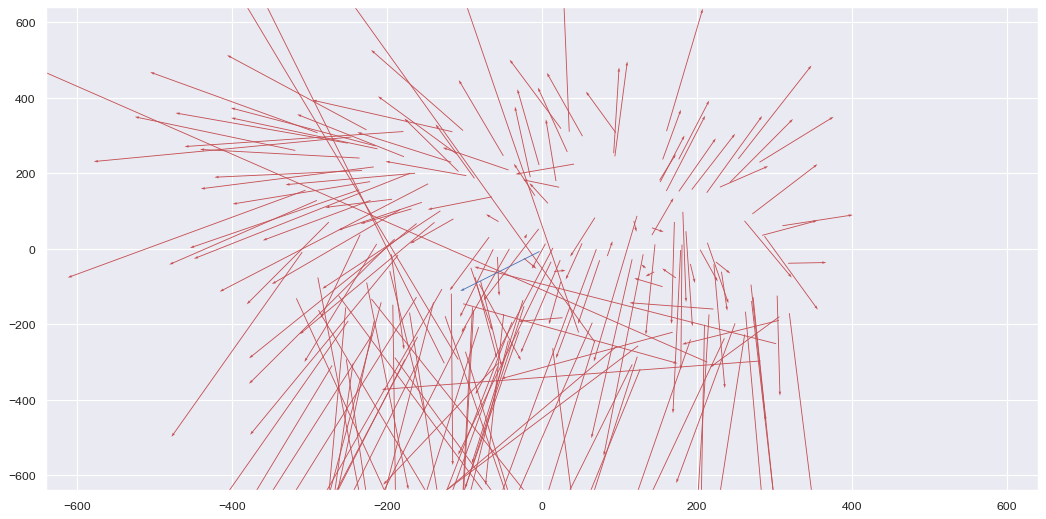

In [72]:
gt, proj, disp, y_angle = get_displacements(100, (0,  -1))
print("y angle is: ", y_angle)
plot_displacements(gt, proj, conf)

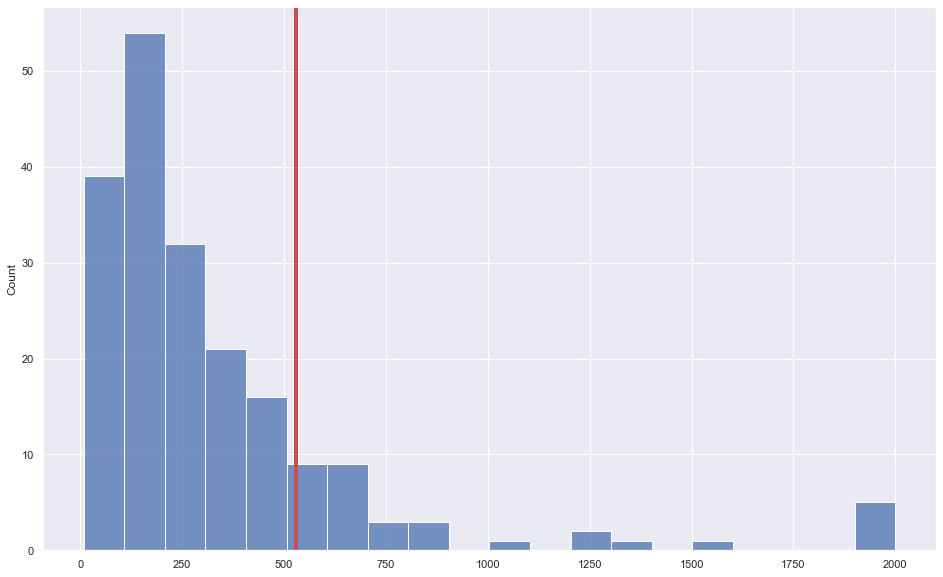

In [73]:
sns.histplot([min(2000, float(elm.norm())) for elm in disp])
plt.axvline(23**2, 0, 1, color='r', linewidth=4)